In [2]:
import torch

from utils import load_model
from models.unet import UNet

import json
from matplotlib import pyplot as plt
import cv2
import numpy as np


In [140]:
run_name = "2023-11-08_19-19-58"

run_path = f"runs/{run_name}/"

In [141]:
train_summary = json.load(open(run_path + "train_summary.json"))

model_name = train_summary["config"]["MODEL"]
IMAGE_SIZE = train_summary["config"]["IMAGE_SIZE"]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [142]:
if model_name == "UNet":
    model = UNet(outSize=(IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)
elif model_name == "SegResNet":
        from monai.networks.nets import SegResNet

        model = SegResNet(in_channels=1, out_channels=2, spatial_dims=2).to(DEVICE)
else:
    raise NotImplementedError

model = load_model(model, run_path + "best_model.pth")

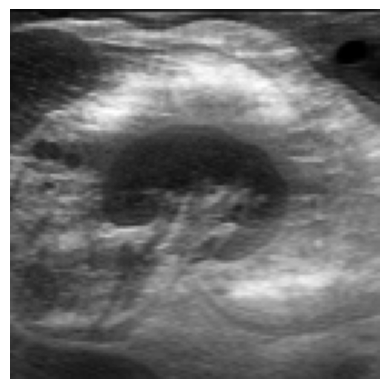

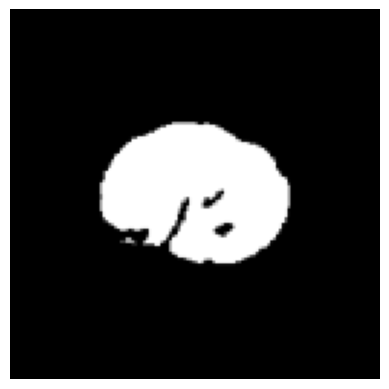

In [143]:
img_path = "datasets/CT2US/test/image/1006.png"
mask_path = "datasets/CT2US/test/mask/1006.png"

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()


In [144]:
with torch.no_grad():
    model.eval()
    img_tensor = torch.tensor(img / 255).unsqueeze(0).unsqueeze(0).float().to(DEVICE)
    pred = model(img_tensor)
    # pred = torch.sigmoid(pred)
    pred = pred.cpu()

# Thresholding
# pred = pred > 0.5
# pred = pred.float()

print(pred.shape)

# plt.imshow(pred, cmap="gray")
# plt.axis("off")
# plt.show()

torch.Size([1, 2, 128, 128])


In [ ]:
target = torch.tensor(mask / 255).unsqueeze(0).unsqueeze(0).float().to(DEVICE)

In [150]:
from monai.metrics import DiceMetric
from monai.transforms import Compose, AsDiscrete
from monai.data import decollate_batch


post_label = Compose([AsDiscrete(to_onehot=2)])
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
dice_acc = DiceMetric(include_background=False, get_not_nans=True)


val_labels_list = decollate_batch(target)
val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]

val_outputs_list = decollate_batch(pred)
val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

dice_acc(y_pred=val_output_convert, y=val_labels_convert)

dice = dice_acc.aggregate()[0]

In [151]:
print(f"Dice score: {dice}")

Dice score: tensor([0.])
